In [5]:
import tweepy #library untuk mengconnectkan dengan twitter
import re #library regex gunanya membuang tulisan yang rancu untuk sentimen analisis
from textblob import TextBlob #begitu pula textblob untuk sentimen analisis
import datetime as DT #untuk menghitung seminggu kebelakang
import yfinance as yf #untuk mengambil data stock saham/crypto
import matplotlib.pyplot as plt #untuk grafik
import numpy #untuk grafik

In [6]:
api_key = "sOeFIF56Ov9p6eaMBsYSGs663" #api yang bisa didapatkan di twitter developer
api_secret_key = "9GHppENqR91ARCyYqzQkEnK2BvWJAEalMxxebFrHEtOuJqfYWd" #ini juga

In [7]:
    auth = tweepy.OAuthHandler(api_key, api_secret_key)
    api = tweepy.API(auth)#untuk mengkonekan dengan API

In [8]:
hasil_mingguan=[]#untuk menyimpan hasil_mingguan
nilai_sentimen_mingguan=[]#untuk menyimpan nilai_sentimen_mingguan
#kode dibawah untuk mengambil data dari seminggu kebelakang
for i in range(7):
    hasilAnalisis=[]#hasil akhir analisis
    today = DT.date.today()
    dayH = today - DT.timedelta(days=i)
    dayHminusOne = dayH - DT.timedelta(days=1)
    print(str(dayH))
    hasilSearch = api.search(q="Tesla", lang="en", count=100, since=str(dayHminusOne), until=str(dayH))

    for tweet in hasilSearch:
        tweet_properties = {} #untuk membuat sebuah tabel menggunakan fungsi dictionary
        tweet_properties["tanggal_tweet"] = tweet.created_at #memasukan tanggal tweet kedalam tweet_properties
        tweet_properties["nama_user"] = tweet.user.screen_name #memasukan nama user tweet kedalam tweet_properties
        tweet_properties["isi_tweet"] = tweet.text #memasukan isi tweet kedalam tweet_properties
        tweet_bersih = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",tweet.text).split())
        #tweet_bersih berguna untuk menghilangkan simbol atau karakter yang membuat isi tweet rancu
        #jika tweet belum di bersihkan maka akan berpengaruh dengan hasil sentimen nantinya
        analysis = TextBlob(tweet_bersih)#library berguna untuk menghitung sentimen analisis dari sebuah kalimat, textblob 
        #dapat menghitung sebuah polariy dari sebuah kalimat
        #lebih optimal jika data sentimen berbahasa inggris karena library dari sananya begitu
        #maka dari itu pada hasilSearch itu lang/bahasanya dideklarasikan menjadi en/english
        #penjelasan mengenai polarity
        #jika nilai polarity kurang dari 0 maka negatif
        #jika nilai polarity samadengan 0 maka netral
        #jika nilai polarity lebih dari 0 maka positif
        #maka jadilah kondisi seperti dibawah
        #begin condition polarity
        if analysis.sentiment.polarity > 0.0:
            tweet_properties["sentimen"] = "positif"
        elif analysis.sentiment.polarity == 0.0:
            tweet_properties["sentimen"] = "netral"
        else:
            tweet_properties["sentimen"] = "negatif"
        #end condition polarity
        #dibawah bertujuan untuk menghapus retweet menghindari tweet duplikat
        if tweet.retweet_count > 0:
            if tweet_properties not in hasilAnalisis:#hasilAnalisis berasal dari variabel hasilAnalisis diatas
                hasilAnalisis.append(tweet_properties)#sebenarnya bukan menghapus semua retweet tapi membatasi retweet hanya boleh 1 saja
        else:
            hasilAnalisis.append(tweet_properties)
        #mengelompokan jenis tweet
        tweet_positif = [t for t in hasilAnalisis if t["sentimen"]=="positif"]
        tweet_netral = [t for t in hasilAnalisis if t["sentimen"]=="netral"]
        tweet_negatif = [t for t in hasilAnalisis if t["sentimen"]=="negatif"]
        
    temp = []
    temp.append(100*len(tweet_positif)/len(hasilAnalisis))
    temp.append(100*len(tweet_netral)/len(hasilAnalisis))
    temp.append(100*len(tweet_negatif)/len(hasilAnalisis))
    nilai_sentimen_mingguan.append(temp)
    hasil_mingguan.append(hasilAnalisis)
    #mengkonversi menjadi persen sesuai dengan jenis tweet
    print("Hasil Sentimen")
    print("positif: ", len(tweet_positif), "({} %)".format(100*len(tweet_positif)/len(hasilAnalisis)))
    print("netral: ", len(tweet_netral), "({} %)".format(100*len(tweet_netral)/len(hasilAnalisis)))
    print("negatif: ", len(tweet_negatif), "({} %)".format(100*len(tweet_negatif)/len(hasilAnalisis)))

2021-10-30


AttributeError: 'API' object has no attribute 'search'

In [12]:
#untuk mengambil kode dari yahoo finance dikarenakan kita menggunakan library harga stock dari yahoo
today = DT.date.today()
week = today - DT.timedelta(days=7)
stock_yahoo = yf.download('TSLA', week, today)#di sini bisa menginputkan nama saham atau crypto yang akan diambil datanya
#data yang diambil juga satu minggu kebelakang sama dengan data sentimen analisisnya agar sejalan ketika dibuat grafiknya
time_series = [today - DT.timedelta(days= (t+1)) for t in range(7)]
positive_sentiment = [p[0] for p in nilai_sentimen_mingguan]
neutral_sentiment = [p[1] for p in nilai_sentimen_mingguan]
negative_sentiment = [p[2] for p in nilai_sentimen_mingguan]
stock_yahoo_clean = [p.split("    ") for p in str(stock_yahoo['Adj Close']).split("\n") if "    " in p]
stock_weekly = []
for x in time_series:
    temp = [p[0] for p in stock_yahoo_clean]
    try:
        stock_weekly.append(float(stock_yahoo_clean[temp.index(str(x))][1]))
    except Exception as e:
        stock_weekly.append(float(0.0))
for idx, x in enumerate(stock_weekly):
    if x == 0.0:
        try:
            if stock_weekly[idx+1] == 0.0:
                stock_weekly[idx] = stock_weekly[idx+2]
            else:
                stock_weekly[idx] = stock_weekly[idx+1]
        except Exception as e:
            print(e)

[*********************100%***********************]  1 of 1 completed


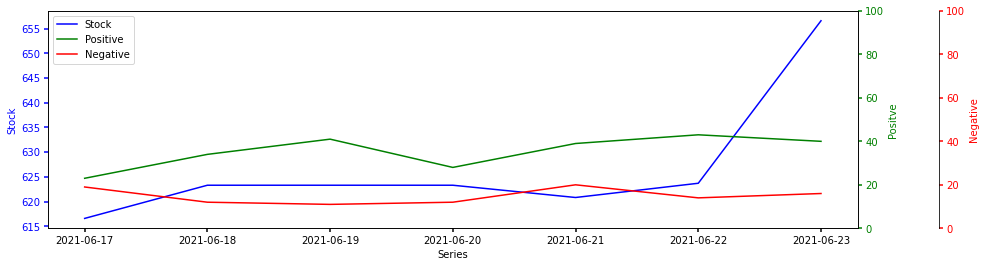

In [13]:
#code untuk memunculkan grafik dari jenis tweet dan harga stock yang diinputkan
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
fig, host = plt.subplots()
fig.subplots_adjust(right=2)
par1 = host.twinx()
par2 = host.twinx()
par2.spines["right"].set_position(("axes", 1.1))
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)
p1, = host.plot(time_series, stock_weekly, "b-", label="Stock")
p2, = par1.plot(time_series, positive_sentiment, "g-", label="Positive")
p3, = par2.plot(time_series, negative_sentiment, "r-", label="Negative")
par1.set_ylim(0, 100)
par2.set_ylim(0, 100)
host.set_xlabel("Series")
host.set_ylabel("Stock")
par1.set_ylabel("Positve")
par2.set_ylabel("Negative")
host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())
tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)
lines = [p1, p2, p3]
host.legend(lines, [l.get_label() for l in lines])
plt.show()